<a href="https://colab.research.google.com/github/LucaBrocco/LCP_B_assignments/blob/Samu-Branch/group2508_Exercise3_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data and labels
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import linalg as la
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 12

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

from sklearn.neighbors import NearestNeighbors

In [3]:
fname,fnamey="x_12d.dat","y_12d.dat"
data=np.loadtxt("DATA/"+fname, delimiter='\t')
y=np.loadtxt("DATA/"+fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  L=D=",D)
x=data

FileNotFoundError: DATA/x_12d.dat not found.

## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

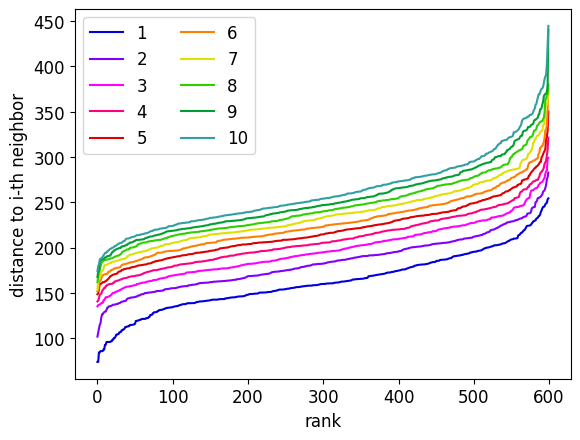

mean minimum distance between points:  162.34622464324366


In [ ]:
nn = 10
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'
d, ind = nbrs.kneighbors(x)
dd=d.T     ### distanza dell'i-esimo vicino per tutti i punti
# note: dd[0] has a trivial set of zeros
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()
mean_min_dist = np.mean(dd[1])
print("mean minimum distance between points: ",mean_min_dist)


## t-SNE visualization, for true labels

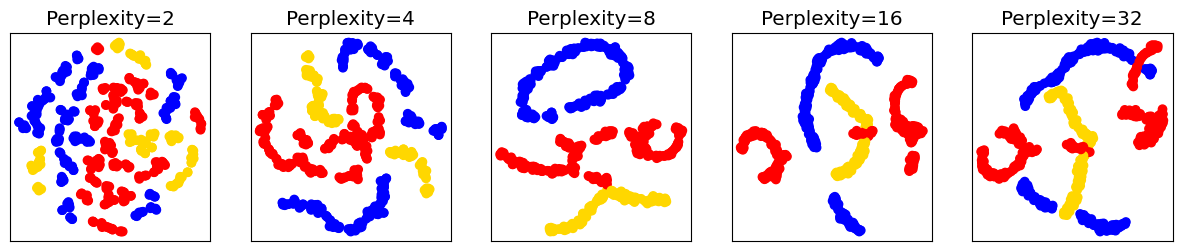

In [ ]:
np.random.seed(0)
n_samples = N
n_components = 2
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## Different random initial states (random_state=i)

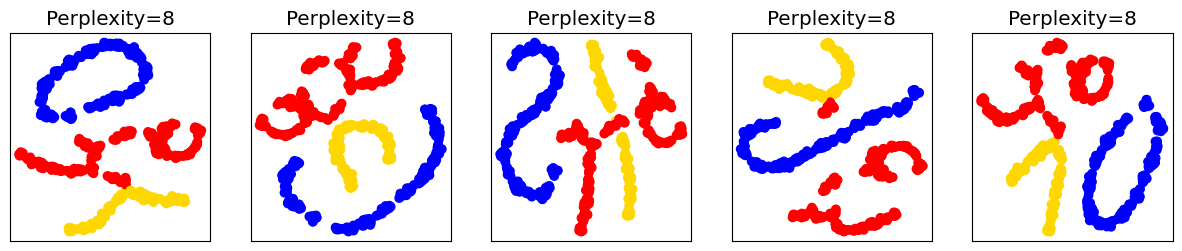

In [ ]:
n_samples = N
n_components = 2
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]

perplexity= 8

for i in range(5):
    np.random.seed(i)
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components,
                         init='random',random_state=i,
                         perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)

plt.show()

## DBSCAN: find labels by applying clustering

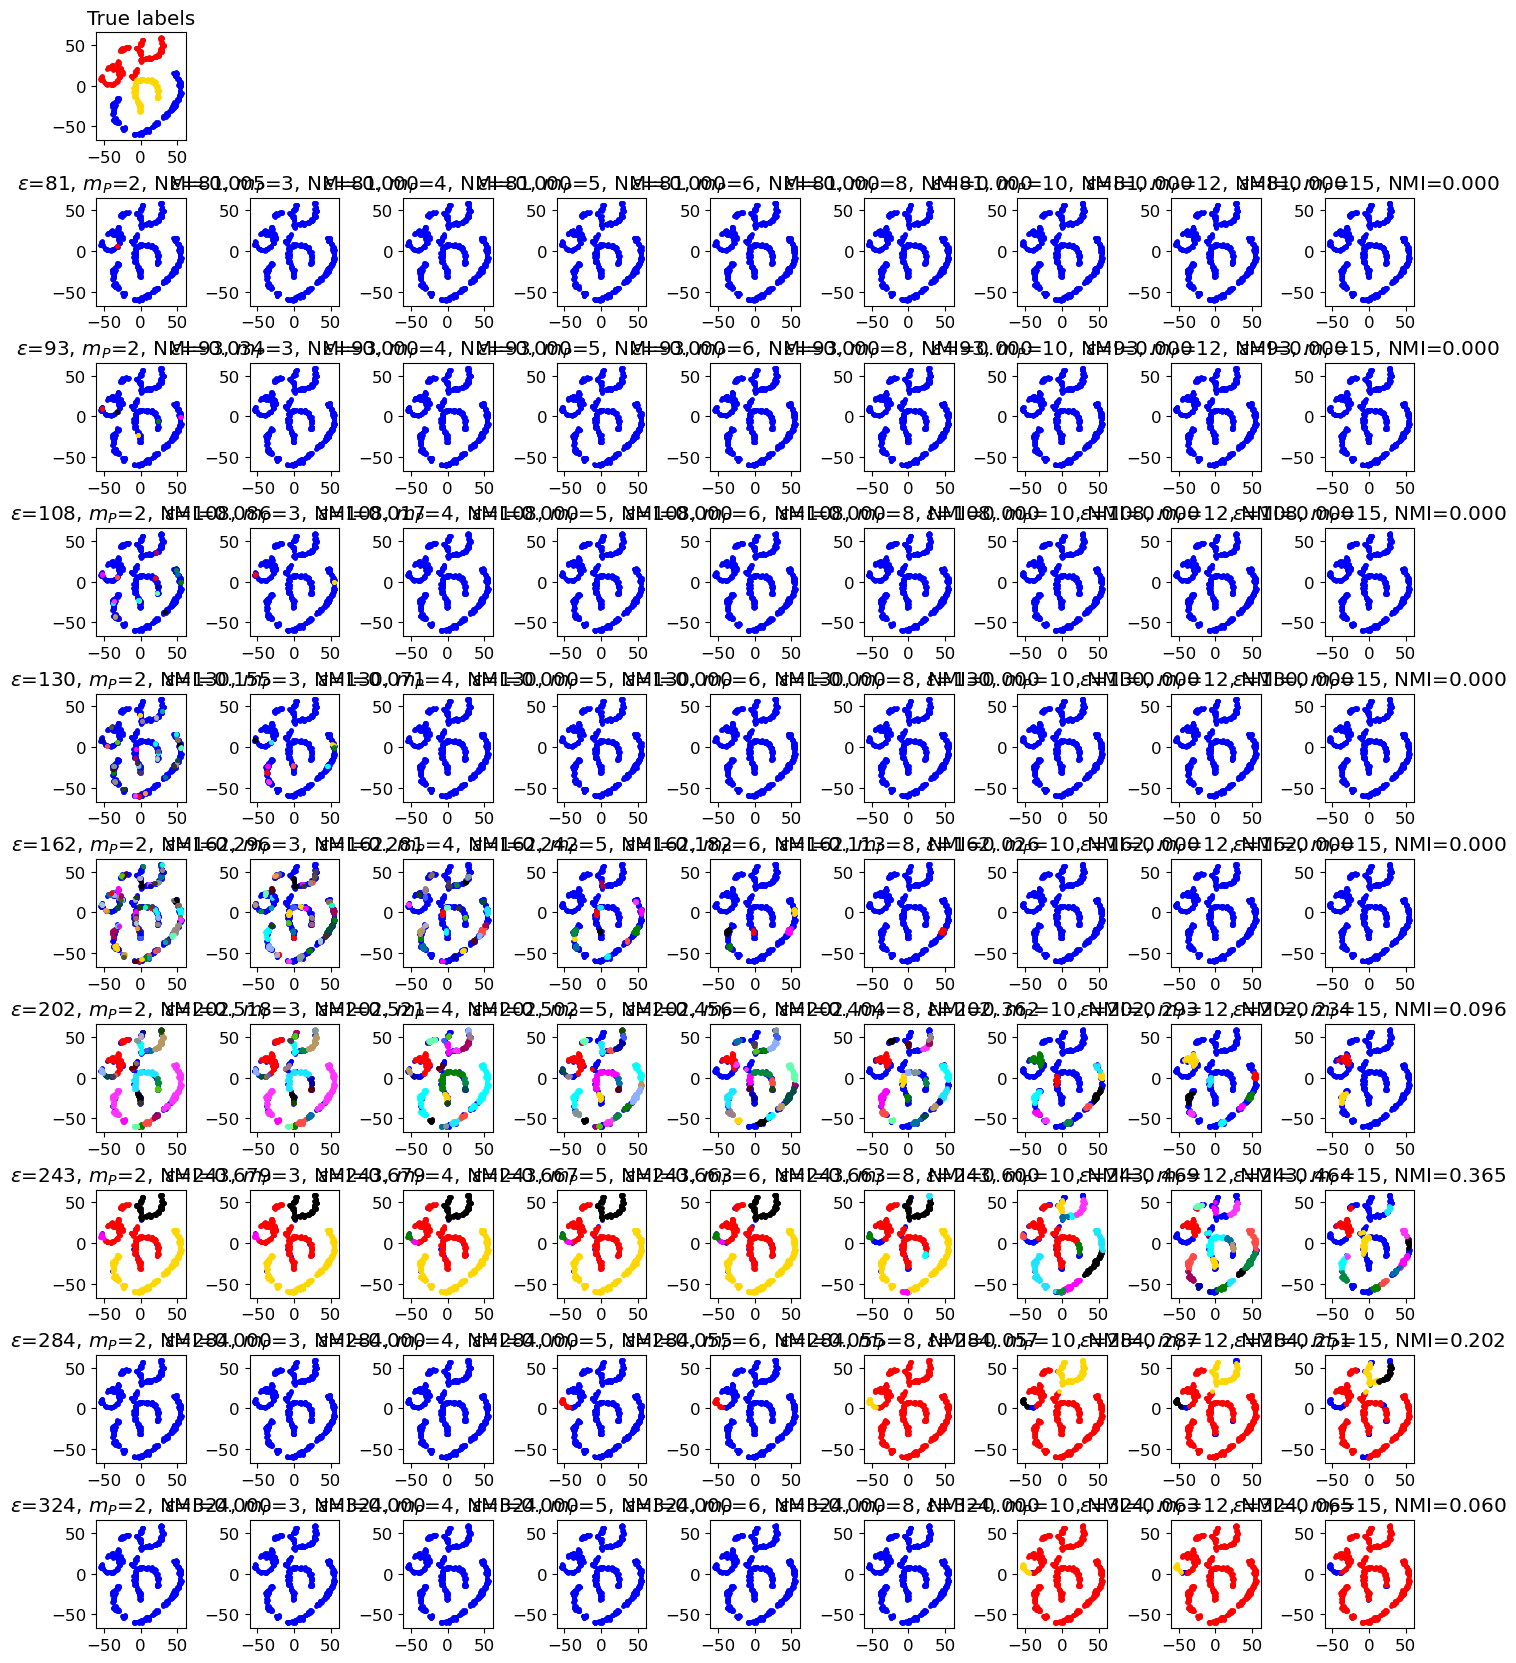

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r/2,r/1.75,r/1.5,r/1.25,r,1.25*r,1.5*r,1.75*r,2*r]

min_sample_range = [2,3,4,5,6,8,10,12,15]
DIMY=len(eps_range)
DIMX=len(min_sample_range)
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(14,16.8))

i,j=0,0
nmi=1
plotting_ax(X2D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i+1,j])
        nmi=NMI(y_hat, y_true)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))


plt.tight_layout(h_pad=0.5)
plt.show()


In [43]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
from tqdm import tqdm
from numba import jit

ms = 6


def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem

def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

#def plotting_ax(X, y, ax):
#    # plotting function
#    for i, yu in enumerate(np.unique(y)):
#        pos = (y == yu)
#        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[2] # best(?) visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

min_sample_range = [i for i in range(2,50)]
eps_range = [i for i in range(1,3*r)]

nmi_matrix = np.zeros((len(eps_range), len(min_sample_range)))
for i, eps in enumerate(tqdm(eps_range, desc="Processing eps values")):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi=NMI(y_hat, y_true)
        nmi_matrix[i, j] = NMI(y_true, y_hat)



Processing eps values: 100%|██████████| 485/485 [04:32<00:00,  1.78it/s]


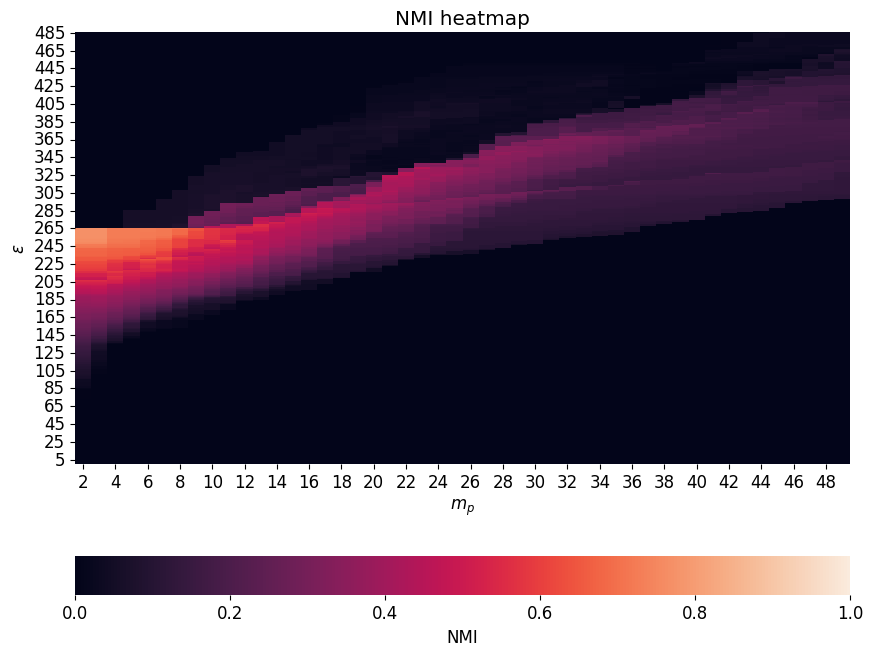

In [50]:
import pandas as pd
df = pd.DataFrame(nmi_matrix, index=eps_range, columns=min_sample_range)
df=df[::-1]
plt.figure(figsize=(10, 8))
sns.heatmap(df,cbar_kws={"label": "NMI","orientation": "horizontal"}, vmax=1)
plt.xlabel('$m_{p}$')
plt.ylabel('$\epsilon$')
plt.title("NMI heatmap")


plt.show()

# PCA

In [ ]:
data = pd.DataFrame(data)
data

In [ ]:
# re-scale the data-set to mean zero and unitary std before executing the PCA   
for column in data.columns: 
    mean = data[column].mean()
    std = data[column].std()
    data[column] = (data[column]-mean)/std
data

In [ ]:
cov = data.cov()
eig_val, eig_vec = la.eig(cov)
eig_val = eig_val.real
eig_vec = eig_vec.real
print(cov, '\n')
print(f"The eigenvalues are: {eig_val}", '\n')
print(f"The eigenvectors are: {eig_vec}", '\n')

In [ ]:
idx_sort = np.argsort(eig_val)[::-1]
eig_val_sort = eig_val[idx_sort]
eig_vec_sort = eig_vec[idx_sort]

var_exp = eig_val_sort / np.sum(eig_val_sort)
cum_var = np.cumsum(var_exp)

features = data.columns.tolist()
pca_list = []
for i in range(len(features)):
    pca_list.append(f"PC_{i+1}")

top_features = []
for i in range(len(features)):
    top_idx = idx_sort[i]
    top_features.append(features[top_idx])

fig = plt.figure(figsize=(16, 8))

plt.bar(pca_list, var_exp, color='Orange', edgecolor='black',alpha=0.75)
plt.plot(pca_list, cum_var, label='Cumulative Variance Explained', marker='o', color='red')
plt.ylabel('Variance Explained',fontsize=20)
plt.xlabel('# Principal component',fontsize=20)

plt.title('Variance explained by each feature',fontsize=26)
plt.legend(loc='best',fontsize=16)

plt.xticks(rotation=45, ha='right', fontsize=45)  
plt.tick_params(axis='y', labelsize=16)  
plt.tick_params(axis='y', labelsize=16)
plt.tick_params(axis='x', labelsize=16)
plt.grid()
plt.show()
print("\n")

In [ ]:
top_k_eig = eig_vec_sort[:, :3]